In [1]:
import sys
import numpy as np
import vtk
import matplotlib.pyplot as plt
import vtk_visualizer as vis
import cv2 as cv
#import br_lectures as br
from hocook import hocook
from planecontact import planecontact
from mobrobsim import mobrobsimanimate, set_goal, set_map
from scipy import ndimage
from PIL import Image
from camerasim import CameraSimulator
from skimage import feature
from skimage.transform import hough_line, hough_line_peaks
from skimage import img_as_ubyte

In [2]:
def imgproc(RGB, camera, camera_height, box_size):
    img_w = camera['img_size'][0]
    img_h = camera['img_size'][1]
    box_w = box_size[0]
    box_h = box_size[1]
    plt.imshow(RGB)
    E=feature.canny(RGB[:,:,0])    
    H, theta, d = hough_line(E)    
    counter = 0
    intersections = [None]*4
    for _, angle, dist in zip(*hough_line_peaks(H, theta, d, min_distance=20, min_angle=20, threshold=50)):

        
        #print('angle=%f, dist=%f' % (angle, dist))
        cs = np.cos(angle)
        sn = np.sin(angle)
        if np.abs(cs) >= np.abs(sn):
            v = np.array([0, img_h-1])
            u = (dist - sn * v) / cs
            plt.plot(u, v, 'g') 
        else:
            u = np.array([0, img_w-1])
            v = (dist - cs * u) / sn
            plt.plot(u, v, 'r') 
        print(u,v)
       # plt.plot(u, v, 'g')  
    plt.show()
        #####            
    #Compute alpha:
    alpha = 0
    ######
    # Visualize red line representing orientation:

    #plt.plot(t_img[0],t_img[1],'r+')
    #x_axis = np.stack((t_img, t_img + x * 150), 0)
    #plt.plot(x_axis[:,0], x_axis[:,1], 'r-')    
    #plt.show()

    ######

    #Compute t:
    t=[0,0,0]

    ######
    return alpha, t

In [3]:

def task4():
    camera = {
        'img_size': [640, 480],
        'focal_length': 1000,
        'principal_point': [320, 240],
        }
    camera_height = 0.5
    box_w = 0.1
    box_h = 0.05
    
    camsim = CameraSimulator(camera, camera_height, [box_w, box_h], 0.05)

    RGB = camsim.get_image()
    print('dtype:')
    print(type(RGB))
    
    
    alpha, t = imgproc(RGB, camera, camera_height, [box_w, box_h])
    
    e_alpha, e_t = camsim.evaluate(alpha, t)
    
    print('orientation error: %f deg position error: %f mm' % (np.rad2deg(e_alpha), 1000 * e_t))
    return RGB

dtype:
<class 'numpy.ndarray'>
[  0 639] [1. 1.]
[  0 639] [478. 478.]
[638. 638.] [  0 479]
[1. 1.] [  0 479]
[  0 639] [439.04796206  84.84447819]
[  0 639] [324.71255528 -29.4909286 ]
[-40.41451884 236.1362601 ] [  0 479]
[190.52558883 467.07636777] [  0 479]


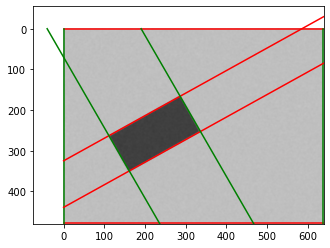

orientation error: 29.300506 deg position error: 502.386228 mm


In [4]:
RGB = task4()
cv_image = img_as_ubyte(RGB)
gray = cv.cvtColor(cv_image, cv.COLOR_BGR2GRAY)
cv.imshow('', gray)
cv.waitKey(0)
cv.destroyAllWindows()

In [12]:
_, im_binary = cv.threshold(gray,127,255,cv.THRESH_BINARY_INV)
cv.imshow('', im_binary)
cv.waitKey(0)
cv.destroyAllWindows()
contours, _ = cv.findContours(im_binary, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

In [14]:
mask = np.zeros(gray.shape, np.uint8)
cv.drawContours(mask, contours, -1,(255,255,255),1)
cv.imshow('', mask)
cv.waitKey(0)
cv.destroyAllWindows()

In [17]:
center ,radius = cv.minEnclosingCircle(contours[0])
print (center)


(223.84060668945312, 258.23394775390625)


In [23]:
rows,cols = gray.shape[:2]
[vx,vy,x,y] = cv.fitLine(contours[0], cv.DIST_L2,0,0.01,0.01)
left = int((-x*vy/vx) + y)
right = int(((cols-x)*vy/vx)+y)
cv.line(mask,(cols-1,right),(0,left),(255,255,255),2)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [24]:
cv.imshow('', mask)
cv.waitKey(0)
cv.destroyAllWindows()